In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from evaluation import evaluate_cf

In [2]:
data = pd.read_csv('./dataset/new/data.csv').drop(columns="Unnamed: 0")
labels = pd.read_csv('./dataset/new/labels.csv')

In [3]:
data.head()

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.104213,0.025389,144.178630,167.02170,115.430466,115.579770,124.897190,124.318660,134.522060,138.791560,...,12.657701,14.509855,18.643116,2.905979,2.252765,2.997747,3.173423,2.699984,2.714874,2.329038
1,0.108329,0.018797,116.932335,116.81062,104.958510,106.856224,107.122960,131.222120,353.585820,128.099060,...,13.057363,13.359251,16.425354,2.510432,2.361842,2.691745,1.427239,2.369561,1.818932,2.163963
2,0.203055,0.022426,319.182280,131.99893,131.480270,121.196110,121.224365,121.071150,131.966660,794.266660,...,12.970959,21.755045,21.717041,1.537123,1.638238,3.026752,1.810459,2.805019,4.571950,4.293758
3,0.119210,0.032156,256.728060,515.78436,224.581180,112.526240,131.550890,131.923520,129.934570,115.061554,...,14.145430,15.075860,19.178572,2.318593,2.508579,1.901502,3.409710,2.446294,1.661938,3.035185
4,0.113839,0.019690,116.983660,108.42759,108.570360,136.068340,135.782400,111.091484,111.612175,104.272835,...,12.054803,14.731396,17.400953,3.947008,1.956441,2.477308,3.416498,1.927335,1.812949,1.570067


In [4]:
for i in range(7):
    print(f"bird{i}:",labels[labels["Aggregated"]==i].shape[0])

bird0: 85358
bird1: 5833
bird2: 8954
bird3: 8198
bird4: 2324
bird5: 5111
bird6: 4222


In [5]:
new_data = []
new_labels = []
for i in range(0,7):
    indices = labels[labels["Aggregated"] == i].sample(9000, replace=True).index.values.tolist()
    new_data.append(data.iloc[indices])
    new_labels.append(labels["Aggregated"].iloc[indices])
new_data = pd.concat(new_data)
new_labels = pd.concat(new_labels)

In [6]:
new_data.shape

(63000, 548)

In [7]:
for i in range(7):
    print(f"bird{i}:",new_labels[new_labels==i].shape[0])

bird0: 9000
bird1: 9000
bird2: 9000
bird3: 9000
bird4: 9000
bird5: 9000
bird6: 9000


In [61]:
def redundant_features_selection(data, threshhold: float = 0.9, visualise: bool = True):
    corr = data.corr()
    corr_np = corr.copy().to_numpy()
    np.fill_diagonal(corr_np, 0)
    redundant_feature_indices = []
    while abs(corr_np).max() > threshhold:
        max_corr_pair = np.unravel_index(abs(corr_np).argmax(), corr_np.shape)
        if np.sum(corr_np[max_corr_pair[1]]) > np.sum(corr_np[max_corr_pair[0]]):
            corr_np[max_corr_pair[1]] = 0
            corr_np[:, max_corr_pair[1]] = 0
            redundant_feature_indices.append(max_corr_pair[1])
        else:
            corr_np[max_corr_pair[0]] = 0
            corr_np[:, max_corr_pair[0]] = 0
            redundant_feature_indices.append(max_corr_pair[0])
    features_to_drop = data.columns[redundant_feature_indices]
    
    if visualise:
        fig, ax = plt.subplots(1,2, figsize=(16,8))
        ax[0].set_title("Original Pearson correlations")
        sns.heatmap(ax=ax[0], data=corr)
        ax[1].set_title(f"After dropping {len(features_to_drop)} most correlated features")
        sns.heatmap(ax=ax[1], data=corr_np)
        plt.show()
        
    return features_to_drop

In [62]:
def take_feature_subset(data, columns_to_drop):
    subset_data = data.drop(columns=columns_to_drop).copy()
    print(f"Subset shape = {subset_data.shape}, original data = {data.shape}")
    return subset_data

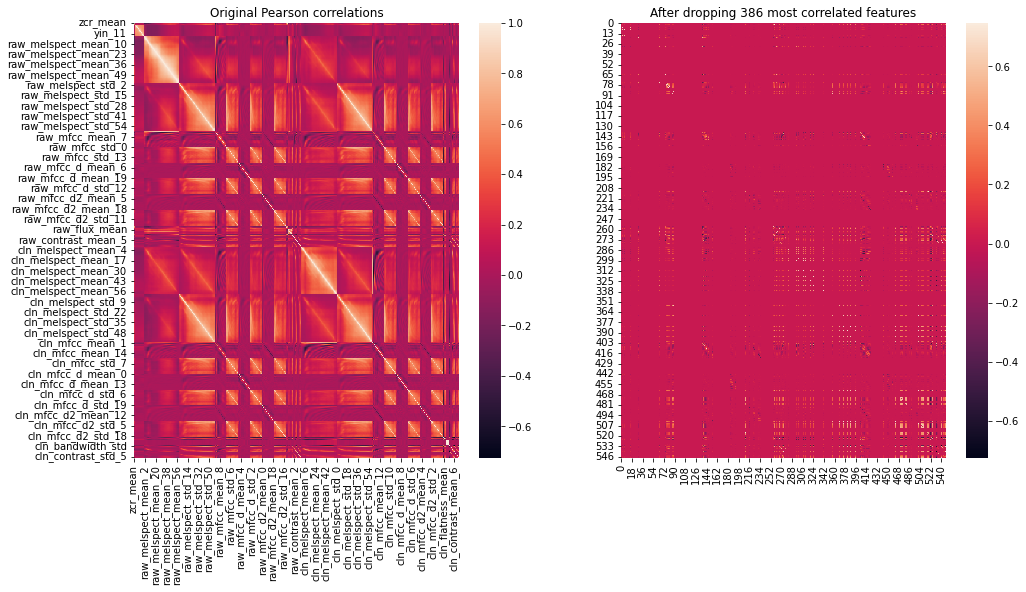

In [69]:
threshold = 0.75
redundant_features = redundant_features_selection(new_data, threshold)

In [70]:
non_redundant_data = take_feature_subset(new_data, redundant_features)

Subset shape = (63000, 162), original data = (63000, 548)


<AxesSubplot:>

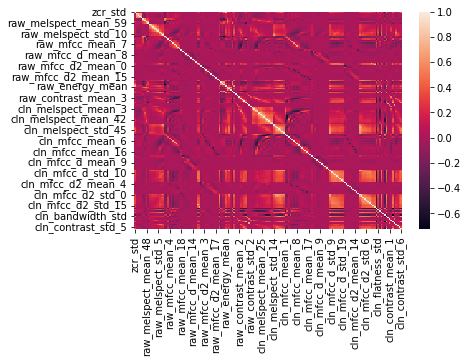

In [71]:
sns.heatmap(non_redundant_data.corr())

In [51]:
non_redundant_data.columns

Index(['zcr_std', 'yin_3', 'yin_8', 'yin_13', 'raw_melspect_mean_0',
       'raw_melspect_mean_7', 'raw_melspect_mean_12', 'raw_melspect_mean_59',
       'raw_mfcc_mean_0', 'raw_mfcc_mean_1',
       ...
       'cln_contrast_mean_4', 'cln_contrast_mean_5', 'cln_contrast_mean_6',
       'cln_contrast_std_0', 'cln_contrast_std_1', 'cln_contrast_std_2',
       'cln_contrast_std_3', 'cln_contrast_std_4', 'cln_contrast_std_5',
       'cln_contrast_std_6'],
      dtype='object', length=158)

In [38]:
non_redundant_data.to_csv('./dataset/new' + '/' + f'balanced_data_subset_{threshold}' + '.csv', index_label='original_index')

In [ ]:
new_labels.to_csv('./dataset/new' + '/' + f'balanced_labels' + '.csv', index_label='original_index')

## OPTIONAL PART OF THE NOTEBOOK: USAGE EXAMPLE
Test classifiers on new_data and on reduced non-redundant data

In [14]:
knn_cf = KNN(n_neighbors=1)
evaluate_cf(knn_cf, new_data, new_labels, 5)

{'Overall': 75.62, 'Class 0': 31.37, 'Class 1': 84.85, 'Class 2': 72.54, 'Class 3': 72.7, 'Class 4': 95.9, 'Class 5': 83.66, 'Class 6': 87.59}
{'Overall': 75.74, 'Class 0': 31.82, 'Class 1': 83.69, 'Class 2': 74.24, 'Class 3': 73.77, 'Class 4': 97.28, 'Class 5': 83.24, 'Class 6': 88.47}
{'Overall': 76.48, 'Class 0': 31.27, 'Class 1': 84.32, 'Class 2': 76.21, 'Class 3': 71.92, 'Class 4': 97.61, 'Class 5': 84.16, 'Class 6': 88.14}
{'Overall': 75.95, 'Class 0': 31.83, 'Class 1': 82.37, 'Class 2': 72.87, 'Class 3': 73.68, 'Class 4': 96.54, 'Class 5': 84.38, 'Class 6': 89.47}
{'Overall': 75.53, 'Class 0': 30.48, 'Class 1': 83.92, 'Class 2': 72.65, 'Class 3': 72.91, 'Class 4': 98.2, 'Class 5': 83.05, 'Class 6': 88.2}
KNeighborsClassifier(n_neighbors=1)
Estimated accuracy with 5-CV: [('Overall', 75.86), ('Class 0', 31.35), ('Class 1', 83.83), ('Class 2', 73.7), ('Class 3', 73.0), ('Class 4', 97.11), ('Class 5', 83.7), ('Class 6', 88.37)]


In [15]:
gnb = GaussianNB()
evaluate_cf(gnb, new_data, new_labels, 5)

{'Overall': 14.2, 'Class 0': 0.06, 'Class 1': 0.0, 'Class 2': 100.0, 'Class 3': 0.0, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.0}
{'Overall': 13.8, 'Class 0': 0.16, 'Class 1': 0.0, 'Class 2': 100.0, 'Class 3': 0.0, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.06}
{'Overall': 14.16, 'Class 0': 0.17, 'Class 1': 0.86, 'Class 2': 0.5, 'Class 3': 99.15, 'Class 4': 0.0, 'Class 5': 0.11, 'Class 6': 0.0}
{'Overall': 13.93, 'Class 0': 0.0, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 100.0, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.0}
{'Overall': 14.17, 'Class 0': 0.06, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 100.0, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.06}
GaussianNB()
Estimated accuracy with 5-CV: [('Overall', 14.05), ('Class 0', 0.09), ('Class 1', 0.17), ('Class 2', 40.1), ('Class 3', 59.83), ('Class 4', 0.0), ('Class 5', 0.02), ('Class 6', 0.02)]


In [39]:
subset_data = pd.read_csv(f'./dataset/new/balanced_data_subset_{threshold}.csv').drop(columns=['original_index'])
loaded_labels = pd.read_csv('./dataset/new/balanced_labels.csv').drop(columns=['original_index'])

In [40]:
knn_cf = KNN(n_neighbors=1)
evaluate_cf(knn_cf, subset_data, new_labels, 5)

{'Overall': 74.1, 'Class 0': 30.41, 'Class 1': 83.97, 'Class 2': 69.07, 'Class 3': 68.19, 'Class 4': 96.23, 'Class 5': 82.57, 'Class 6': 87.59}
{'Overall': 74.74, 'Class 0': 32.13, 'Class 1': 84.82, 'Class 2': 69.34, 'Class 3': 70.21, 'Class 4': 97.93, 'Class 5': 82.84, 'Class 6': 88.12}
{'Overall': 74.96, 'Class 0': 31.15, 'Class 1': 84.67, 'Class 2': 71.26, 'Class 3': 70.79, 'Class 4': 96.53, 'Class 5': 81.01, 'Class 6': 87.7}
{'Overall': 75.03, 'Class 0': 31.15, 'Class 1': 84.15, 'Class 2': 70.12, 'Class 3': 70.94, 'Class 4': 97.28, 'Class 5': 81.54, 'Class 6': 89.53}
{'Overall': 74.43, 'Class 0': 31.42, 'Class 1': 84.36, 'Class 2': 69.21, 'Class 3': 70.05, 'Class 4': 97.24, 'Class 5': 83.22, 'Class 6': 86.25}
KNeighborsClassifier(n_neighbors=1)
Estimated accuracy with 5-CV: [('Overall', 74.65), ('Class 0', 31.25), ('Class 1', 84.39), ('Class 2', 69.8), ('Class 3', 70.04), ('Class 4', 97.04), ('Class 5', 82.24), ('Class 6', 87.84)]


In [41]:
gnb = GaussianNB()
evaluate_cf(gnb, subset_data, new_labels, 5)

{'Overall': 13.95, 'Class 0': 0.06, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 0.0, 'Class 4': 0.0, 'Class 5': 99.94, 'Class 6': 0.11}
{'Overall': 13.76, 'Class 0': 0.0, 'Class 1': 0.0, 'Class 2': 99.94, 'Class 3': 0.0, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.0}
{'Overall': 13.89, 'Class 0': 0.0, 'Class 1': 100.0, 'Class 2': 0.0, 'Class 3': 0.0, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.11}
{'Overall': 13.94, 'Class 0': 0.11, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 100.0, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.0}
{'Overall': 14.12, 'Class 0': 0.0, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 0.0, 'Class 4': 100.0, 'Class 5': 0.0, 'Class 6': 0.11}
GaussianNB()
Estimated accuracy with 5-CV: [('Overall', 13.93), ('Class 0', 0.03), ('Class 1', 20.0), ('Class 2', 19.99), ('Class 3', 20.0), ('Class 4', 20.0), ('Class 5', 19.99), ('Class 6', 0.07)]
